# MeerKAT Proposal Reviewer Allocation Problem

Richard Armstrong 
June 2022

Solve the Reviewer Assignment Problem for a set of MeerKAT Proposals

REQUIREMENTS
* Reviewers must have between 10 and 20 proposals to review 
* Some reviewers have requested a maximum of 10 proposals
* Proposals are reviewed 4 times each (`coverage`)
* Must exclude reviewers from reviewing proposals they are involved in

In [1]:
#!pip install --upgrade pip
#!pip install numpy matplotlib pandas openpyxl cvxopt

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from numpy import genfromtxt

%matplotlib inline 
pylab.rcParams['figure.figsize'] = 9, 6

In [3]:
coverage = 4   # Number of reviews per proposal
lower_bound_reviewer_load = 10 # Minimum number of reviews per reviewer

## Load Data

In [4]:
# load the list of proposals and their categories into a dataframe
df_cat = pd.read_csv('proposal_scientific_categories_MKT-22.csv', sep=';')
df_cat['Category_List'] = df_cat['CATEGORY LIST'].apply(lambda x: eval(x))
n_p = n_proposals = len(df_cat)
df_cat

,PSS ID,CATEGORY LIST,Category_List
0,MKT-22003,[11],[11]
1,MKT-22004,"[3,7]","[3, 7]"
2,MKT-22005,"[3,4]","[3, 4]"
3,MKT-22006,[4],[4]
4,MKT-22007,"[4,6]","[4, 6]"
...,...,...,...
127,MKT-22155,[11],[11]
128,MKT-22158,"[2,4,6]","[2, 4, 6]"
129,MKT-22159,"[2,4,5]","[2, 4, 5]"
130,MKT-22160,[10],[10]


In [5]:
# load the reviewer conflict dataframe
df_conflict = pd.read_csv('science_cross_check_MKT-22.csv', sep=';')
df_conflict['Proposals'] = df_conflict['PROPOSAL LIST'].apply(lambda x: x.strip('][').split(','))
df_conflict.head(25)

,ID,PROPOSAL LIST,Proposals
0,6,[MKT-22087],[MKT-22087]
1,7,"[MKT-22043,MKT-22054]","[MKT-22043, MKT-22054]"
2,9,[MKT-22009],[MKT-22009]
3,10,"[MKT-22064,MKT-22065]","[MKT-22064, MKT-22065]"
4,12,"[MKT-22004,MKT-22029,MKT-22032,MKT-22059,MKT-2...","[MKT-22004, MKT-22029, MKT-22032, MKT-22059, M..."
5,14,[MKT-22084],[MKT-22084]
6,15,"[MKT-22005,MKT-22137]","[MKT-22005, MKT-22137]"
7,17,[MKT-22081],[MKT-22081]
8,21,"[MKT-22051,MKT-22079,MKT-22100,MKT-22121]","[MKT-22051, MKT-22079, MKT-22100, MKT-22121]"
9,26,"[MKT-22013,MKT-22137]","[MKT-22013, MKT-22137]"


In [148]:
roe = np.genfromtxt('reviewer_observation_expertise_MKT-22.csv', delimiter=',', skip_header=1)
poc = np.genfromtxt('proposal_observation_categories_MKT-22.csv', delimiter=',',skip_header=1)
#roe, poc

roe[:,1]

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.])

In [150]:
# load the self-identified reviewer competency scores per catagory into a dataframe

df_rev_score = pd.read_csv('reviewer_scientific_expertise_MKT-22.csv')
#df_rev_score.index = df_rev_score['REVIEWER ID']

rev_score = genfromtxt('reviewer_scientific_expertise_MKT-22.csv', delimiter=',')

# Create vector with max number of reviews per reviewer 
n_r = n_reviewers = len(df_rev_score)
reviewers_props = 20*np.ones(n_r)
#limit10_list = [28,29]
#reviewers_props[limit10_list] = 10
df_rev_score['N_max'] = reviewers_props  # Make column with max number of reviews for each reviewer

scientific_categories = pd.read_csv('scientific_categories_MKT-22.csv')
scientific_categories.index = scientific_categories['CATEGORY ID']

df_rev_score.columns = ['CATEGORY ID',1,2,3,4,5,6,7,8,9,10,11,12,13,'N_max']

og_rev_idx = np.array(df_rev_score['CATEGORY ID'])

df_rev_score.head(21)
np.column_stack((og_rev_idx, np.array(df_rev_score[11]), roe[:,1]))

array([[ 2.,  4.,  1.],
       [ 4.,  0.,  1.],
       [ 6.,  0.,  1.],
       [ 7.,  2.,  1.],
       [ 9.,  0.,  0.],
       [10.,  1.,  1.],
       [12.,  2.,  0.],
       [13.,  5.,  0.],
       [14.,  1.,  0.],
       [15.,  0.,  1.],
       [17.,  1.,  1.],
       [19.,  0.,  1.],
       [21.,  0.,  1.],
       [26.,  2.,  1.],
       [27.,  1.,  0.],
       [28.,  0.,  1.],
       [29.,  0.,  1.],
       [31.,  0.,  1.],
       [32.,  2.,  1.],
       [33.,  0.,  1.],
       [34.,  0.,  0.],
       [35.,  0.,  1.],
       [36.,  0.,  1.],
       [37.,  0.,  1.],
       [38.,  0.,  0.],
       [39.,  0.,  1.],
       [40.,  6.,  0.],
       [41.,  0.,  1.],
       [42.,  2.,  0.],
       [43.,  0.,  1.],
       [44.,  0.,  0.],
       [45.,  0.,  1.],
       [46.,  0.,  0.],
       [47.,  0.,  1.],
       [48.,  0.,  1.],
       [49.,  0.,  0.],
       [50.,  1.,  1.],
       [51.,  0.,  0.],
       [52.,  0.,  0.],
       [53.,  0.,  1.],
       [54.,  0.,  0.],
       [55.,  0.

In [7]:
print('reviewers, proposals: ', n_r, n_p)

reviewers, proposals:  47 132


## Derived Data Structures

In [93]:
# create a binary numpy array(/mask) from the reviewer conflict dataframe: 
# i.e. set to 0 if conflict, else 1
conflict_mask = np.ones((n_r, n_p))
conflict_counter = 0
print('total number of conflicts in mask before: ', conflict_mask.flatten().shape[0] - np.count_nonzero(conflict_mask))

rev_idx = np.array(df_rev_score['CATEGORY ID'].index)

for row_idx, row in df_conflict.iterrows():
    rev_pos = int(*np.where(og_rev_idx==row[0]))
    for col_idx, prop in enumerate(df_conflict['Proposals'][row_idx]):
        prop_pos = df_cat[df_cat['PSS ID'] == prop].index[0]
        #print(prop, col_idx, prop_pos, rev_pos)
        conflict_mask[int(rev_pos)][prop_pos] = 0
        conflict_counter+=1
        
print('total number of conflicts in mask after: ', conflict_mask.flatten().shape[0] - np.count_nonzero(conflict_mask))
print('conflict_counter: ', conflict_counter)
#print(conflict_mask[n_r-3], n_r-3, conflict_mask.shape)

#print(f'number of conflicts for each reviewer: \n{np.column_stack((og_rev_idx,n_p-np.sum(conflict_mask, axis=1))).astype(int)}')

print(f'sum of conflicts: {int(np.sum(n_p-np.sum(conflict_mask, axis=1)))}')

total number of conflicts in mask before:  0
total number of conflicts in mask after:  89
conflict_counter:  89
sum of conflicts: 89


In [9]:
# create a binary array (/mask) of reviewer expertise > .0
zeroes_mask = np.where(np.array(df_rev_score.transpose()) > 0., 1, 0)[1:-1]
np.count_nonzero(zeroes_mask), zeroes_mask.shape

(426, (13, 47))

In [10]:
# create a numerical array of the reviewer scores dataframe
rev_scores = np.array(df_rev_score.transpose())[1:-1]
np.count_nonzero(rev_scores), rev_scores.shape[0], rev_scores.shape[1]


(426, 13, 47)

In [11]:
#SCRATCH
for row_idx, row in df_conflict.iterrows():
    pass#print(row_idx, row)
#df_conflict['Proposals']
df_cat['PSS ID'].index

df_conflict['Proposals'][1]
prop = 'MKT-22155'#'MKT-22084'
df_cat[df_cat['PSS ID'] == prop].index[0]
#np.array(df_rev_score['CATEGORY ID'])
#int(*np.where(og_rev_idx==59))

127

## Plots

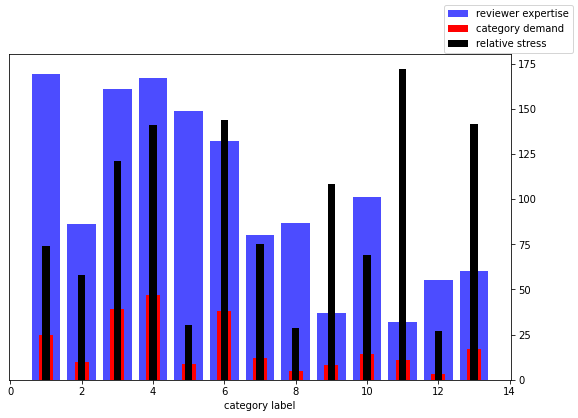

In [12]:
# Make a bar plot of all the proposal categories and numerical reviewer expertise 

all_topics_list = []
all_topics_count = np.zeros(df_rev_score.transpose()[1:-1].shape[0])

for idx, topic_set in enumerate(df_cat['Category_List']): # run through each proposal
    #print(idx, topic_set)
    for topic in topic_set: # run through each topic in each proposal
        all_topics_count[topic-1] += 1 # add one to the demand per mention
        #print(topic, df_rev_score[topic][1])
        all_topics_list.append(topic)
        
fig, ax = plt.subplots()#figsize=(16,8))

ax.bar(range(1, rev_scores.shape[0]+1), [row.sum() for row in rev_scores], alpha=0.7, label = 'reviewer expertise', color='b')
ax.bar(range(1,rev_scores.shape[0]+1), all_topics_count, label = 'category demand', color = 'r', width=0.4)
#ax.hist(np.array(all_topics_list), histtype='step', linewidth=3, align='mid', bins=1000, label = 'category demand')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.bar(range(1,rev_scores.shape[0]+1), 5*10**2*np.array(all_topics_count)[0:13]/[row.sum() for row in rev_scores][0:13], width=0.2, label = 'relative stress', color='k')

fig.legend()
plt.xlabel('category label')
plt.savefig('relative_stress.png')

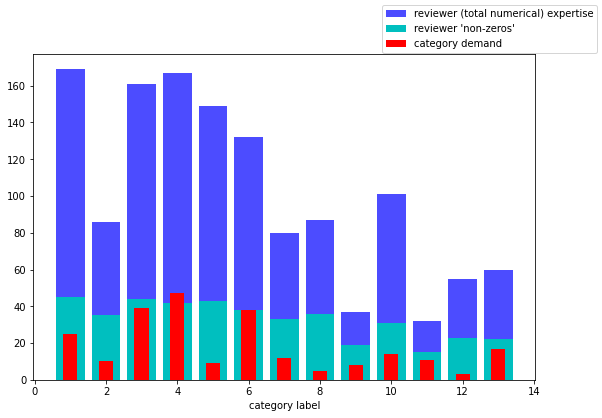

In [13]:
# Make a bar plot of all the proposal categories and binary reviewer expertise 
    
fig, ax = plt.subplots()
ax.bar(range(1,14), [row.sum() for row in rev_scores], alpha=0.7, label = 'reviewer (total numerical) expertise', color='b')
ax.bar(range(1, rev_scores.shape[0]+1), [row.sum() for row in zeroes_mask], label = 'reviewer \'non-zeros\'', color='c')
ax.bar(range(1,rev_scores.shape[0]+1), all_topics_count, label = 'category demand', color = 'r', width=0.4)

plt.xlabel('category label')
fig.legend()
plt.show()

## Affinity Matrix

In [99]:
# ---------------
# AFFINITY MATRIX
# ---------------

# create the affinity matrix
affinity = np.zeros((len(df_rev_score),len(df_cat)))

print('creation done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
#affinity

# set the affinity to the MAXimum of ANY keyword
max = 0
for row_idx, row in enumerate(affinity):
    #print(row_idx, row)
    #for cell_idx, cell in enumerate(row):
    for cell_idx, topic_set in enumerate(df_cat['Category_List']):
        #print(topic_set, cell_idx)
        for topic in topic_set:
            #print(topic)
            max = np.maximum(max, rev_scores[topic-1][row_idx])
            #if ((topic != 14) and (topic != 15)): 
                #max = np.maximum(max, df_rev_score[topic][row_idx+1])
            # NOTE only consider the 13 subject categories 
        affinity[row_idx, cell_idx] = max/10 # normalise to between 0 and 1
        max=0
        
print('set up affinities done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

#-----------        
     
# Set constraints in the affinity matrix :
# i.e. 1. Maximum over observation categories 
#      2. Make sure there are not zeros in EVERY category, 
#      3. reviewer/proposal conflicts (science_cross_check)
# by setting affinity to 0 (which is actually a soft constraint, but wusually suffices)

# Observation Category
rev_obs_exp = np.genfromtxt('reviewer_observation_expertise_MKT-22.csv', delimiter=',', skip_header=1)
prop_obs_cat = np.genfromtxt('proposal_observation_categories_MKT-22.csv', delimiter=',', skip_header=1)[:,1]
#print(prop_obs_cat)
        
for row_idx, row in enumerate(rev_obs_exp):
    #print (rev_obs_exp[row_idx][1:])
    for col_idx, col in enumerate(prop_obs_cat):
        #print (row_idx, col_idx, col, row[1:])
        if row[int(col)] == 0: 
            #print (affinity[row_idx][col_idx])
            affinity[row_idx][col_idx] = 0.
print('Obs cat done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

            
# check there is at least one non-zero
'''set_zero = False
for row_idx, row in enumerate(affinity):#row_idx is reviewer ID
    for cell_idx, topic_set in enumerate(df_cat['Category_List']):#cell_idx is the proposal id, topic_set is the list of topics
        for topic in topic_set:
            if df_rev_score[topic][row_idx]==0.: set_zero = True # if there are ANY '0' experience ratings
        if set_zero == True: affinity[row_idx, cell_idx] = 0.
        set_zero = False

print('at least one nonzero done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
'''

# mask out conflicts of interest:
affinity = affinity*conflict_mask
print('set conflicts done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])

'''
# apply a non-linear scaling to the affinity 
affinity = affinity + np.where(affinity>0.3, 0.4, 0.)
print('non_linear scaling done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])
'''

creation done (47, 132) zeros: 6204 of 6204
set up affinities done (47, 132) zeros: 851 of 6204
Obs cat done (47, 132) zeros: 1638 of 6204
set conflicts done (47, 132) zeros: 1724 of 6204


"\n# apply a non-linear scaling to the affinity \naffinity = affinity + np.where(affinity>0.3, 0.4, 0.)\nprint('non_linear scaling done', affinity.shape, 'zeros:', affinity.flatten().shape[0] - np.count_nonzero(affinity), 'of', affinity.flatten().shape[0])\n"

## Prepare arrays for LP

In [15]:
# --------------------------------------------------------------------------------------------
# convert arrays to a set of stored numpy arrays for the Linear Program (LP) optimisation code
# --------------------------------------------------------------------------------------------

# assign the maximum number of proposals per reviewer
loads = np.genfromtxt('science_max_reviews.csv', skip_header=1, delimiter=',')[:,1]

# set the lower bound of proposals to review to be 10
loads_lb = 10*np.ones(affinity.shape[0])

# set the coverage (i.e. number of reviews per paper) to be exactly 4
covs = 4*np.ones(affinity.shape[1])

loads_lb.shape, loads.shape

((47,), (47,))

-------------------------------------------------

In [16]:
# save array to disk, to transfer to server with Gurobi license
np.save('scores.npy', affinity)
np.save('loads.npy', loads)
np.save('loads-lb.npy', loads_lb)
np.save('covs.npy', covs)

### Note: move to sherlock

+ copy over scores.npy (the storage name of the afinity matrix) to sherlock.sdp.kat.ac.za (which has the gurobi license file):
`
rsync -avz scores.npy richarms@sherlock.sdp.kat.ac.za:/home/richarms/src/fair-matching/data/mk/
`
+ then:
`ssh sherlock.sdp.kat.ac.za`
+ run the linear program
`
cd /home/richarms/src/fair-matching
source venv/bin/activate
source bin/setup.sh
sh bin/exp/basic.sh config/mk/basic-lb.json
exit
`
+ and copy back the assignment.npy 

`rsync -avz richarms@sherlock.sdp.kat.ac.za:/home/richarms/src/fair-matching/exp_out/mk/basic-lb/{DATE}/results/assignment.npy .`

## Code to evaluate LP result


In [34]:
# load the assignment matrix from the LP
# The assignment matrix is a sparse binary array of dim n_reviewers * n_proposals 
# with nonzero entries for a positive assignment
assignment = np.load('assignment.npy')
assignment = assignment.astype(int)
assignment[np.where(og_rev_idx==40)].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 14,  16,  31,  55,  62,  66,  74,  77,  79, 116]))

In [35]:
# Do manual adjustments (highly risky!)
at = assignment.transpose()
at[np.where(df_cat['PSS ID']=='MKT-22003'), np.where(og_rev_idx==32)] = 0
at[np.where(df_cat['PSS ID']=='MKT-22003'), np.where(og_rev_idx==40)] = 1
at[np.where(df_cat['PSS ID']=='MKT-22155'), np.where(og_rev_idx==34)] = 0
at[np.where(df_cat['PSS ID']=='MKT-22155'), np.where(og_rev_idx==26)] = 1

assignment[np.where(og_rev_idx==40)].nonzero()
#at[np.where(df_cat['PSS ID']=='MKT-22155'), np.where(og_rev_idx==26)]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([  0,  14,  16,  31,  55,  62,  66,  74,  77,  79, 116]))

In [36]:
## CHECK
## Sanity check -- check that the trace of the affinity and assignment match that produced by LP
np.sum(np.diag(np.matmul(np.transpose(affinity), assignment))), np.trace(np.matmul(np.transpose(affinity), assignment))

(292.79999999999995, 292.79999999999995)

In [37]:
# SCRATCH
print(np.count_nonzero(np.transpose(assignment)[0]))
print(np.transpose(assignment)[0])
print(np.count_nonzero((assignment)[12]))
print((assignment).transpose()[-5].nonzero())

4
[1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
10
(array([ 0,  7, 13, 18]),)


In [21]:
# Gene Matrix
################

# The assignment matrix may be expressed as a 'gene matrix' (an inherited term): a dense array 
# of reviewers assigned to each proposal, (as opposed to the assignment matrix, which is a sparse binary 
# array of dim n_reviewers * n_proposals with nonzero entries for a positive assignment)
gene_matrix = np.zeros((n_proposals, coverage))
gene_matrix_indexes = np.zeros((n_proposals, coverage))

# original reviewer index
#og_rev_idx = np.array(df_rev_score['CATEGORY ID'])

# The reviewer_assignment is the logical opposite of the gene matrix: for each reviewer,
# it is a list of their associated proposals
reviewer_assignment = np.empty((n_reviewers), dtype=object)

# set the first element of the reviewer assignment vector to be the original reviewer 
# index, as a string
for idx, r in enumerate(reviewer_assignment):
    reviewer_assignment[idx] = str(og_rev_idx[idx])



for col_idx, col in enumerate(assignment.transpose()):
    # set the gene matrix to the indices of each non-zero element in the assignment
    gene_matrix[col_idx] = np.nonzero(col)[0]
    # set up the correct original reviewer IDs
    for rev_idx, rev in enumerate(gene_matrix[col_idx]):
        gene_matrix_indexes[col_idx][rev_idx] = og_rev_idx[int(rev)]
    # augment the string with each fo the {n_min, n_max} proposals that reviewer should review
    for i in np.nonzero(col)[0]:
        reviewer_assignment[i] = reviewer_assignment[i] + ', ' + df_cat['PSS ID'][col_idx]

        
gene_matrix = gene_matrix.astype(int)
gene_matrix_indexes = gene_matrix_indexes.astype(int)

print("This is the LP result, expressed as a set of (4) reviewers (by original ID) per proposal: \n", 
      np.column_stack((df_cat['PSS ID'], gene_matrix_indexes)))

print(reviewer_assignment)


This is the LP result, expressed as a set of (4) reviewers (by original ID) per proposal: 
 [['MKT-22003' 2 7 26 40]
 ['MKT-22004' 27 39 51 55]
 ['MKT-22005' 35 37 43 58]
 ['MKT-22006' 4 6 10 57]
 ['MKT-22007' 33 37 39 53]
 ['MKT-22008' 28 33 36 43]
 ['MKT-22009' 44 46 51 54]
 ['MKT-22011' 12 39 44 55]
 ['MKT-22012' 39 54 55 56]
 ['MKT-22013' 33 36 37 58]
 ['MKT-22015' 4 6 10 57]
 ['MKT-22016' 15 35 42 59]
 ['MKT-22017' 41 45 46 55]
 ['MKT-22018' 34 47 48 61]
 ['MKT-22019' 14 40 42 50]
 ['MKT-22020' 12 38 44 54]
 ['MKT-22022' 14 40 42 57]
 ['MKT-22023' 27 35 46 51]
 ['MKT-22025' 12 44 51 52]
 ['MKT-22027' 15 17 32 35]
 ['MKT-22028' 14 21 42 50]
 ['MKT-22029' 9 44 46 55]
 ['MKT-22030' 7 29 49 59]
 ['MKT-22032' 9 44 46 52]
 ['MKT-22033' 13 29 47 56]
 ['MKT-22034' 33 36 37 53]
 ['MKT-22035' 2 19 31 43]
 ['MKT-22036' 2 19 31 43]
 ['MKT-22037' 4 10 19 57]
 ['MKT-22038' 17 35 53 59]
 ['MKT-22039' 6 15 26 31]
 ['MKT-22040' 2 13 32 40]
 ['MKT-22042' 9 38 51 54]
 ['MKT-22043' 28 36 39 43]
 ['MK

In [22]:
gene_matrix_indexes[-5]

array([ 2, 13, 26, 32])

In [23]:
# Save proposal assignments and reviewer assignemnts to CSV files
pd.DataFrame(np.column_stack((df_cat['PSS ID'], gene_matrix_indexes.astype(int)))).to_csv('Proposal_assignment.csv')
pd.DataFrame(np.column_stack((og_rev_idx, reviewer_assignment))).to_csv('Reviewer_assignment.csv')

Fernando's matrix zeros:  0
Fernando's Extended zeros:  62
Fernando's matrix: mean, median, minimum sum: 6.0 5.556818181818182 13
[[4 2 2 6 'MKT-22003']
 [6 6 6 6 'MKT-22004']
 [6 6 6 6 'MKT-22005']
 [4 5 5 5 'MKT-22006']
 [6 6 6 6 'MKT-22007']
 [6 6 6 6 'MKT-22008']
 [6 6 6 6 'MKT-22009']
 [6 6 6 6 'MKT-22011']
 [6 6 6 6 'MKT-22012']
 [6 6 6 6 'MKT-22013']
 [4 5 5 5 'MKT-22015']
 [5 6 6 5 'MKT-22016']
 [6 6 6 6 'MKT-22017']
 [5 6 6 6 'MKT-22018']
 [6 6 6 6 'MKT-22019']
 [6 6 6 6 'MKT-22020']
 [5 1 6 3 'MKT-22022']
 [6 6 6 6 'MKT-22023']
 [6 6 6 6 'MKT-22025']
 [5 6 5 6 'MKT-22027']
 [6 3 6 6 'MKT-22028']
 [6 6 6 6 'MKT-22029']
 [6 6 4 5 'MKT-22030']
 [6 6 6 6 'MKT-22032']
 [6 6 6 6 'MKT-22033']
 [6 6 6 6 'MKT-22034']
 [6 5 5 6 'MKT-22035']
 [6 5 5 6 'MKT-22036']
 [4 5 5 5 'MKT-22037']
 [6 6 6 5 'MKT-22038']
 [5 5 6 5 'MKT-22039']
 [4 5 2 6 'MKT-22040']
 [6 6 6 6 'MKT-22042']
 [6 6 6 6 'MKT-22043']
 [6 6 6 6 'MKT-22044']
 [6 6 6 6 'MKT-22045']
 [6 6 6 6 'MKT-22046']
 [6 6 6 6 'MKT-2204

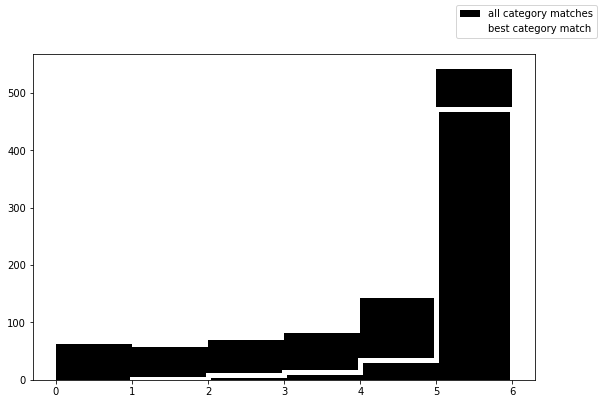

In [125]:
# -----------
# Fernando's Matrix 
# -----------

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 4))
hi_cont_arr = np.zeros((n_p, 4))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []
all_hicont_scores = []


for cell_idx, topic_set in enumerate(df_cat['Category_List']):#iterate over proposals
    rev_a = np.zeros(4)
    hi_a = np.zeros(4)
    for topic in topic_set: #iterate over topic proposals
        if (topic <= 13):
            for rev_idx, rev in enumerate(gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
        else:
            for rev_idx, rev in enumerate(gene_matrix[cell_idx]):#iterate over reviewers
                hi_a[rev_idx] = np.maximum(hi_a[rev_idx], rev_scores[topic-1][rev])
                all_hicont_scores.append(rev_scores[topic-1][rev])
        
    #print(rev_a.astype(int))#, hi_a.astype(int))
    rev_max_arr[cell_idx] = rev_a
    hi_cont_arr[cell_idx] = hi_a
    
print('Fernando\'s matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

fig, ax = plt.subplots()
ax.hist(all_assigned_affinities, bins=int(np.max(all_assigned_affinities)-np.min(all_assigned_affinities)),histtype='stepfilled', linewidth=5,  label='all category matches', color='k')
ax.hist(rev_max_arr.astype(int).flatten(), bins=np.max(rev_max_arr.astype(int).flatten())-np.min(rev_max_arr.astype(int).flatten()), histtype='step',linewidth=5, label='best category match',color='w')#.sum(axis=0)
fig.legend()

#print('Extended: mean, median:', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
#print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

rev_max_arr = rev_max_arr.astype(int)
print('Fernando\'s matrix: mean, median, minimum sum:', np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)))
#print('argmin: ', np.argmin(rev_max_arr.sum(axis=1)), ',sum: ', rev_max_arr.sum(axis=1))
#print(rev_max_arr.sum(axis=0))
print(np.column_stack((rev_max_arr, df_cat['PSS ID'])))


plt.savefig('Fernandos_hist.png')
plt.show()




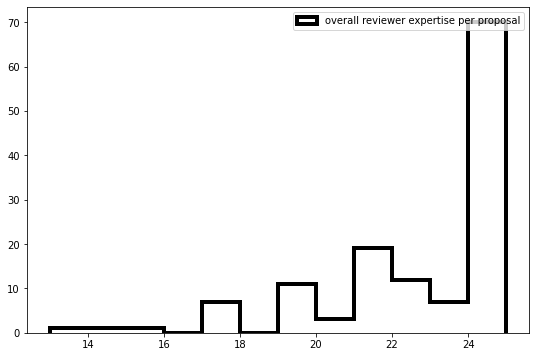

median, mean: 24.0 22.227272727272727


array([[14, 'MKT-22003'],
       [24, 'MKT-22004'],
       [24, 'MKT-22005'],
       [19, 'MKT-22006'],
       [24, 'MKT-22007'],
       [24, 'MKT-22008'],
       [24, 'MKT-22009'],
       [24, 'MKT-22011'],
       [24, 'MKT-22012'],
       [24, 'MKT-22013'],
       [19, 'MKT-22015'],
       [22, 'MKT-22016'],
       [24, 'MKT-22017'],
       [23, 'MKT-22018'],
       [24, 'MKT-22019'],
       [24, 'MKT-22020'],
       [15, 'MKT-22022'],
       [24, 'MKT-22023'],
       [24, 'MKT-22025'],
       [22, 'MKT-22027'],
       [21, 'MKT-22028'],
       [24, 'MKT-22029'],
       [21, 'MKT-22030'],
       [24, 'MKT-22032'],
       [24, 'MKT-22033'],
       [24, 'MKT-22034'],
       [22, 'MKT-22035'],
       [22, 'MKT-22036'],
       [19, 'MKT-22037'],
       [23, 'MKT-22038'],
       [21, 'MKT-22039'],
       [17, 'MKT-22040'],
       [24, 'MKT-22042'],
       [24, 'MKT-22043'],
       [24, 'MKT-22044'],
       [24, 'MKT-22045'],
       [24, 'MKT-22046'],
       [24, 'MKT-22047'],
       [22, 

In [138]:
plt.hist(rev_max_arr.sum(axis=1), histtype='step', bins=range(np.min(rev_max_arr.sum(axis=1)),2+np.max(rev_max_arr.sum(axis=1))), linewidth=4,color='k',label='overall reviewer expertise per proposal')
#bins=1+np.max(rev_max_arr.sum(axis=1))-np.min(rev_max_arr.sum(axis=1))
plt.legend()
plt.savefig('total_reviewer_expertise_per_proposal_hist.png')
plt.show()
print('median, mean:', np.median(rev_max_arr.sum(axis=1)),np.mean(rev_max_arr.sum(axis=1)))
np.column_stack((rev_max_arr.sum(axis=1),df_cat['PSS ID']))
#rev_max_arr.sum(axis=1)

#range(14,25)

528


12

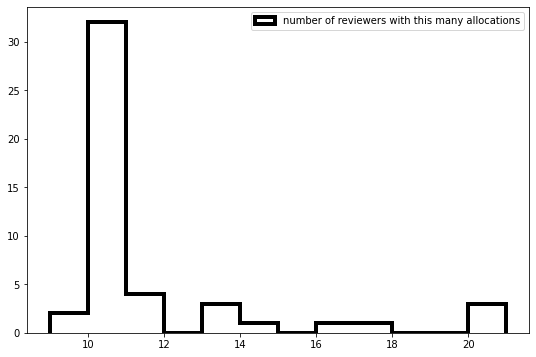

In [140]:
#column sums of the assignment: number of reviews per reviewer
col_sum=[]
print(np.count_nonzero(assignment))
for el in assignment:
    col_sum.append(np.count_nonzero(el))#print(np.count_nonzero(el))

#print(np.column_stack((og_rev_idx,col_sum)))

plt.hist(col_sum, histtype='step', bins=range(np.min(col_sum), 2+np.max(col_sum)),linewidth=4, color='k',label='number of reviewers with this many allocations')
#bins=np.max(col_sum) - np.min(col_sum)
plt.legend()
plt.savefig('reviewers_hist.png')

np.max(col_sum) - np.min(col_sum)+1

In [27]:
# check for conflicts of interest in final assignment

icm = np.where(conflict_mask == 1, 0, 1)
#zeroes_mask = np.where(np.array(df_rev_score.transpose()) > 0., 1, 0)[1:-1]
final_conflicts = assignment * icm
print('final conflicts:', np.count_nonzero(final_conflicts))
#icm[6], conflict_mask[6]

final conflicts: 0


In [ ]:
# check no assignments outside observation category



Fernando's (random) matrix zeros:  76
Fernando's (random) Extended zeros:  206
Random Extended: mean, median 2.759453781512605 3.0
2627.0 952 2.759453781512605
Random: mean, median 4.0 3.414772727272727 0.0 452 746


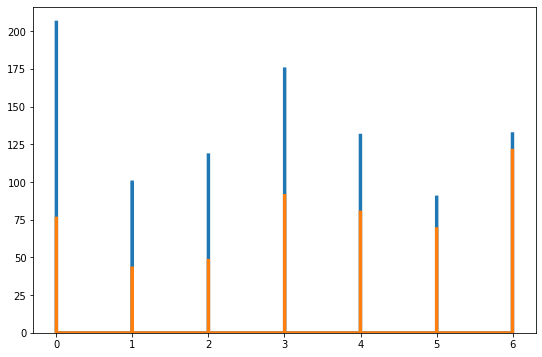

In [28]:
# VERIFICATION:
# Essentially this answers the question of what would be the base case? 
# What distribution of scores would a random assignment yield?

# -----------
# RANDOM Fernando's Matrix (reviewer score distribution)
# -----------

# random gene_matrix
r_gene_matrix = np.random.randint(0, n_r, size=(n_p,4))
r_gene_matrix+1

# max reviewer score matrix ('Fernando's Matrix')
rev_max_arr = np.zeros((n_p, 4))
# all reviewer score list ('Extended Fernando's List')
all_assigned_affinities = []


for cell_idx, topic_set in enumerate(df_cat['Category_List']):#iterate over proposals
    rev_a = np.zeros(4)
    for topic in topic_set: #iterate over topic proposals
        #if ((topic != 14) and (topic != 15)):
        if (topic <= 13):
            for rev_idx, rev in enumerate(r_gene_matrix[cell_idx]):#iterate over reviewers
                rev_a[rev_idx] = np.maximum(rev_a[rev_idx], rev_scores[topic-1][rev])
                all_assigned_affinities.append(rev_scores[topic-1][rev])
                #print(cell_idx, topic, rev_idx, rev, rev_scores[topic-1][rev])
                
    #print(rev_a)
    rev_max_arr[cell_idx] = rev_a
    
print('Fernando\'s (random) matrix zeros: ', rev_max_arr.flatten().shape[0] - np.count_nonzero(rev_max_arr))
print('Fernando\'s (random) Extended zeros: ', len(all_assigned_affinities) - np.count_nonzero(np.array(all_assigned_affinities)))

plt.hist(all_assigned_affinities, histtype='step', linewidth=3, bins=1000)

print('Random Extended: mean, median', np.mean(all_assigned_affinities), np.median(all_assigned_affinities))
print(np.sum(all_assigned_affinities), len(all_assigned_affinities), np.sum(all_assigned_affinities)/len(all_assigned_affinities))

np.mean(rev_max_arr.sum(axis=1))

plt.hist(rev_max_arr.astype(int).flatten(), histtype='step', linewidth=3, bins=1000)#.sum(axis=0)
print('Random: mean, median',np.median(rev_max_arr), np.mean(rev_max_arr), np.min(rev_max_arr.sum(axis=1)), np.count_nonzero(rev_max_arr.astype(int).flatten()), np.count_nonzero(all_assigned_affinities))

plt.savefig('random_hist.png')